In [1]:
import sys
import warnings
from pathlib import Path
from argparse import ArgumentParser
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD, Adam
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torchvision.models.quantization as models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tqdm import tqdm

import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Time spent. Around two hours - mainly because of PyTorchLightning & some CUDA issues.

In [2]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        groups: Number of blocked connections from input channels to output channels. Default: 1
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        
    Returns:
        Convoluted layer of kernel size=3, with specified out_planes
    
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution
    
    Args:
        in_planes: number of channels in input image
        out_planes: number of channels produced by convolution
        stride: stride of the convolution. Default: 1
        
    Returns:
        Convoluted layer of kernel size=1, with specified out_planes
        
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None, quantize=False):
        super(BasicBlock, self).__init__()
        self.quantize = quantize
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        # FloatFunction()
        self.skip_add = nn.quantized.FloatFunctional()
        

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        # Notice the addition operation in both scenarios
        if self.quantize:
            out = self.skip_add.add(out, identity)
        else:
            out += identity

        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block=BasicBlock, layers=[2, 2, 2, 2], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, mnist=False, quantize=True, pretrained = None):
        super(ResNet, self).__init__()
        self.quantize = quantize
        if mnist:
            num_channels = 1
        else:
            num_channels = 3
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace 
            # the 2x2 stride with a dilated convolution instead.
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(num_channels, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer, quantize=self.quantize))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer, quantize=self.quantize))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # Input are quantized
        if self.quantize:
            x = self.quant(x)
    
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        # Outputs are dequantized
        if self.quantize:
            x = self.dequant(x)
        
        return x

    def forward(self, x):
         # See note [TorchScript super()]
        return self._forward_impl(x)

In [3]:
class ResNetClassifier(pl.LightningModule):
    """ Modified from source: https://github.com/Stevellen/ResNet-Lightning/blob/master/resnet_classifier.py"""
    def __init__(self, num_classes, resnet_version,
                train_path, vld_path, test_path=None, 
                optimizer='adam', lr=1e-3, batch_size=16,
                transfer=True, tune_fc_only=True):
        super().__init__()
            
        self.__dict__.update(locals())
        resnets = {
            18: ResNet,
            50: models.resnet50
        }
        optimizers = {'adam': Adam, 'sgd': SGD}
        self.optimizer = optimizers[optimizer]
        self.criterion = nn.BCEWithLogitsLoss() if num_classes == 2 else nn.CrossEntropyLoss()
        self.resnet_model = resnets[resnet_version](pretrained=transfer, num_classes = 1000)
        
        linear_size = list(self.resnet_model.children())[-3].in_features
        self.resnet_model.fc = nn.Linear(linear_size, num_classes)

        if tune_fc_only:
            for child in list(self.resnet_model.children())[:-3]:
                for param in child.parameters():
                    param.requires_grad = False

        self.train_path = train_path
        self.vld_path = vld_path
        self.test_path = test_path
        self.batch_size = batch_size

    def forward(self, X):
        return self.resnet_model(X)

    def configure_optimizers(self):
        return self.optimizer(self.parameters(), lr=self.lr)
    
    def train_dataloader(self):
        transform = transforms.Compose([
                transforms.Resize((500,500)),
                transforms.RandomHorizontalFlip(0.3),
                transforms.RandomVerticalFlip(0.3),
                transforms.RandomApply([
                    transforms.RandomRotation(180)                    
                ]),
                transforms.ToTensor(),
                transforms.Normalize((0.48232,), (0.23051,))
        ])
        img_train = ImageFolder(self.train_path, transform=transform)
        return DataLoader(img_train, batch_size=self.batch_size, shuffle=True)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        if self.num_classes == 2:
            y = F.one_hot(y, num_classes=2).float()
        loss = self.criterion(preds, y)

        acc = (y == torch.argmax(preds, axis = 1)) \
            .type(torch.FloatTensor).mean()

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def val_dataloader(self):
        transform = transforms.Compose([
                transforms.Resize((500,500)),
                transforms.ToTensor(),
                transforms.Normalize((0.48232,), (0.23051,))
        ])
        
        img_val = ImageFolder(self.vld_path, transform=transform)
        
        return DataLoader(img_val, batch_size=1, shuffle=False)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        if self.num_classes == 2:
            y = F.one_hot(y, num_classes=2).float()
        
        loss = self.criterion(preds, y)
 
        acc = (y == torch.argmax(preds, axis = 1)) \
            .type(torch.FloatTensor).mean()
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_epoch=True, prog_bar=True, logger=True)
        
        
        self.log("val_auc", acc, on_epoch=True, prog_bar=True, logger=True)


    def test_dataloader(self):
        transform = transforms.Compose([
                transforms.Resize((500,500)),
                transforms.ToTensor(),
                transforms.Normalize((0.48232,), (0.23051,))
        ])
        
        img_test = ImageFolder(self.test_path, transform=transform)
        
        return DataLoader(img_test, batch_size=1, shuffle=False)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        if self.num_classes == 2:
            y = F.one_hot(y, num_classes=2).float()
        
        loss = self.criterion(preds, y)
        acc = (torch.argmax(y,1) == torch.argmax(preds,1)) \
                .type(torch.FloatTensor).mean()
        self.log("test_loss", loss, on_step=True, prog_bar=True, logger=True)
        self.log("test_acc", acc, on_step=True, prog_bar=True, logger=True)
        
    def quantize_model(self, fbgemm, device = "cpu"):
        train_loader = self.train_dataloader()
        test_loader = self.test_dataloader()
        model = self.resnet_model
        model = model.eval().to(device)
        modules_to_fuse = [['conv1', 'bn1'],
                   ['layer1.0.conv1', 'layer1.0.bn1'],
                   ['layer1.0.conv2', 'layer1.0.bn2'],
                   ['layer1.1.conv1', 'layer1.1.bn1'],
                   ['layer1.1.conv2', 'layer1.1.bn2'],
                   ['layer2.0.conv1', 'layer2.0.bn1'],
                   ['layer2.0.conv2', 'layer2.0.bn2'],
                   ['layer2.0.downsample.0', 'layer2.0.downsample.1'],
                   ['layer2.1.conv1', 'layer2.1.bn1'],
                   ['layer2.1.conv2', 'layer2.1.bn2'],
                   ['layer3.0.conv1', 'layer3.0.bn1'],
                   ['layer3.0.conv2', 'layer3.0.bn2'],
                   ['layer3.0.downsample.0', 'layer3.0.downsample.1'],
                   ['layer3.1.conv1', 'layer3.1.bn1'],
                   ['layer3.1.conv2', 'layer3.1.bn2'],
                   ['layer4.0.conv1', 'layer4.0.bn1'],
                   ['layer4.0.conv2', 'layer4.0.bn2'],
                   ['layer4.0.downsample.0', 'layer4.0.downsample.1'],
                   ['layer4.1.conv1', 'layer4.1.bn1'],
                   ['layer4.1.conv2', 'layer4.1.bn2']]
        model = torch.quantization.fuse_modules(model, modules_to_fuse)
        if fbgemm:
            model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
        else:
            model.qconfig = torch.quantization.default_qconfig
        torch.quantization.prepare(model, inplace=True)
        model.eval()
        with torch.no_grad():
            for data, target in tqdm(train_loader):
                model(data.to(device))
        self.resnet_model = torch.quantization.convert(model, inplace=True)

In [4]:
def auroc(model, loader_name='val', N_classes=4, device = "cpu"):
    """ Modified from source: https://gist.github.com/khizirsiddiqui"""
    model.eval()
    y_test = []
    y_score = []
    dataloaders =  {"val" : model.val_dataloader(), "train": model.train_dataloader(), "test":model.test_dataloader()}
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders[loader_name]):
            inputs = inputs.to(device)
            y_test.append(F.one_hot(classes, N_classes).numpy())
            
            try:
                bs, ncrops, c, h, w = inputs.size()
            except:
                bs, c, h, w = inputs.size()
                ncrops = 1
            if ncrops > 1:
                outputs = model.forward(inputs.view(-1, c, h, w))
                outputs = outputs.view(bs, ncrops, -1).mean(1)
            else:
                outputs = model(inputs)
            y_score.append(outputs.cpu().numpy())
    y_test = np.array([t.ravel() for t in y_test])
    y_score = np.array([t.ravel() for t in y_score])
    # print(y_true)
    # print(y_pred)

    """
    compute ROC curve and ROC area for each class in each fold
    """

    fpr = dict()
    tpr = dict()
    local_roc_auc = dict()
    for i in range(N_classes):
        fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]),np.array(y_score[:, i]))
        local_roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    local_roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(N_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= N_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    local_roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(dpi=300)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(local_roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(local_roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = [['aqua', 'darkorange', 'cornflowerblue'] for _ in range(100)]
    colors = [item for sublist in colors for item in sublist]

    for i, color in zip(range(N_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, local_roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-1e-2, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristics')
    plt.legend(loc="lower right")
    plt.show()

In [5]:
num_classes = 4
train_set = "./archive/dataset/train/"
vld_set = "./archive/dataset/test/"
test_set = "./archive/dataset/test/"
batch_size = 16
transfer = True
tune_fc_only = True#implemented for resnet 50 
optimizer = "adam"
learning_rate = 1e-3

num_epochs = 1
gpus = 1
quantization_aware_training = False

for resnet_version in [50, 18]:
    if quantization_aware_training:
        from pytorch_lightning.callbacks import QuantizationAwareTraining
        from pytorch_lightning.callbacks import ModelPruning
        callbacks = [ModelPruning("l1_unstructured", amount=0.5), QuantizationAwareTraining()]
    else:
        callbacks = []

    # Instantiate Model
    model = ResNetClassifier(num_classes = 4, resnet_version = resnet_version,
                            train_path = train_set, vld_path = vld_set, test_path = test_set,
                            optimizer = optimizer, lr = learning_rate,
                            batch_size = batch_size, transfer = transfer, tune_fc_only = tune_fc_only)

    # Instantiate lightning trainer and train model
    trainer_args = {'gpus': gpus, 'max_epochs': num_epochs, 
                    'callbacks':callbacks}
    trainer = pl.Trainer(**trainer_args)
    trainer.fit(model)

    # Save trained model
    save_path = 'trained_model_unquantized_resnet_' + str(resnet_version) +'.ckpt'
    trainer.save_checkpoint(save_path)

    auroc(model.to(device))
    plt.show()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type              | Params
---------------------------------------------------
0 | criterion    | CrossEntropyLoss  | 0     
1 | resnet_model | QuantizableResNet | 23.5 M
---------------------------------------------------
8.2 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.065    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

- A deep neural network with ResNet18 Backbone was chosen because of its known capacity in producing good predictions at acceptable runtimes (lower as VGG). The simple blocked design makes it easy to make modifications if necessary
- The PyTorch implementation uses Lightning for clean code
- The model could be trained until convergence of the loss can be observed (Tensorboard).
- Typical hyperparameters of a comparable tasks were used. A systematic hyperparametersearch was not performed.
- Nonetheless a high accurcy is achieved. As the dataset has imbalanced classes the AUC of the ROC is more informative as an evaluation metric. It indicates the performance for each class.

In [6]:
model.quantize_model(True, "cpu")
torch.save(model.state_dict(), "resnet18_quantized.ckpt")

100%|███████████████████████████████████████████| 73/73 [01:50<00:00,  1.52s/it]


In [7]:
model.load_state_dict(torch.load("resnet18_quantized.ckpt"))

<All keys matched successfully>

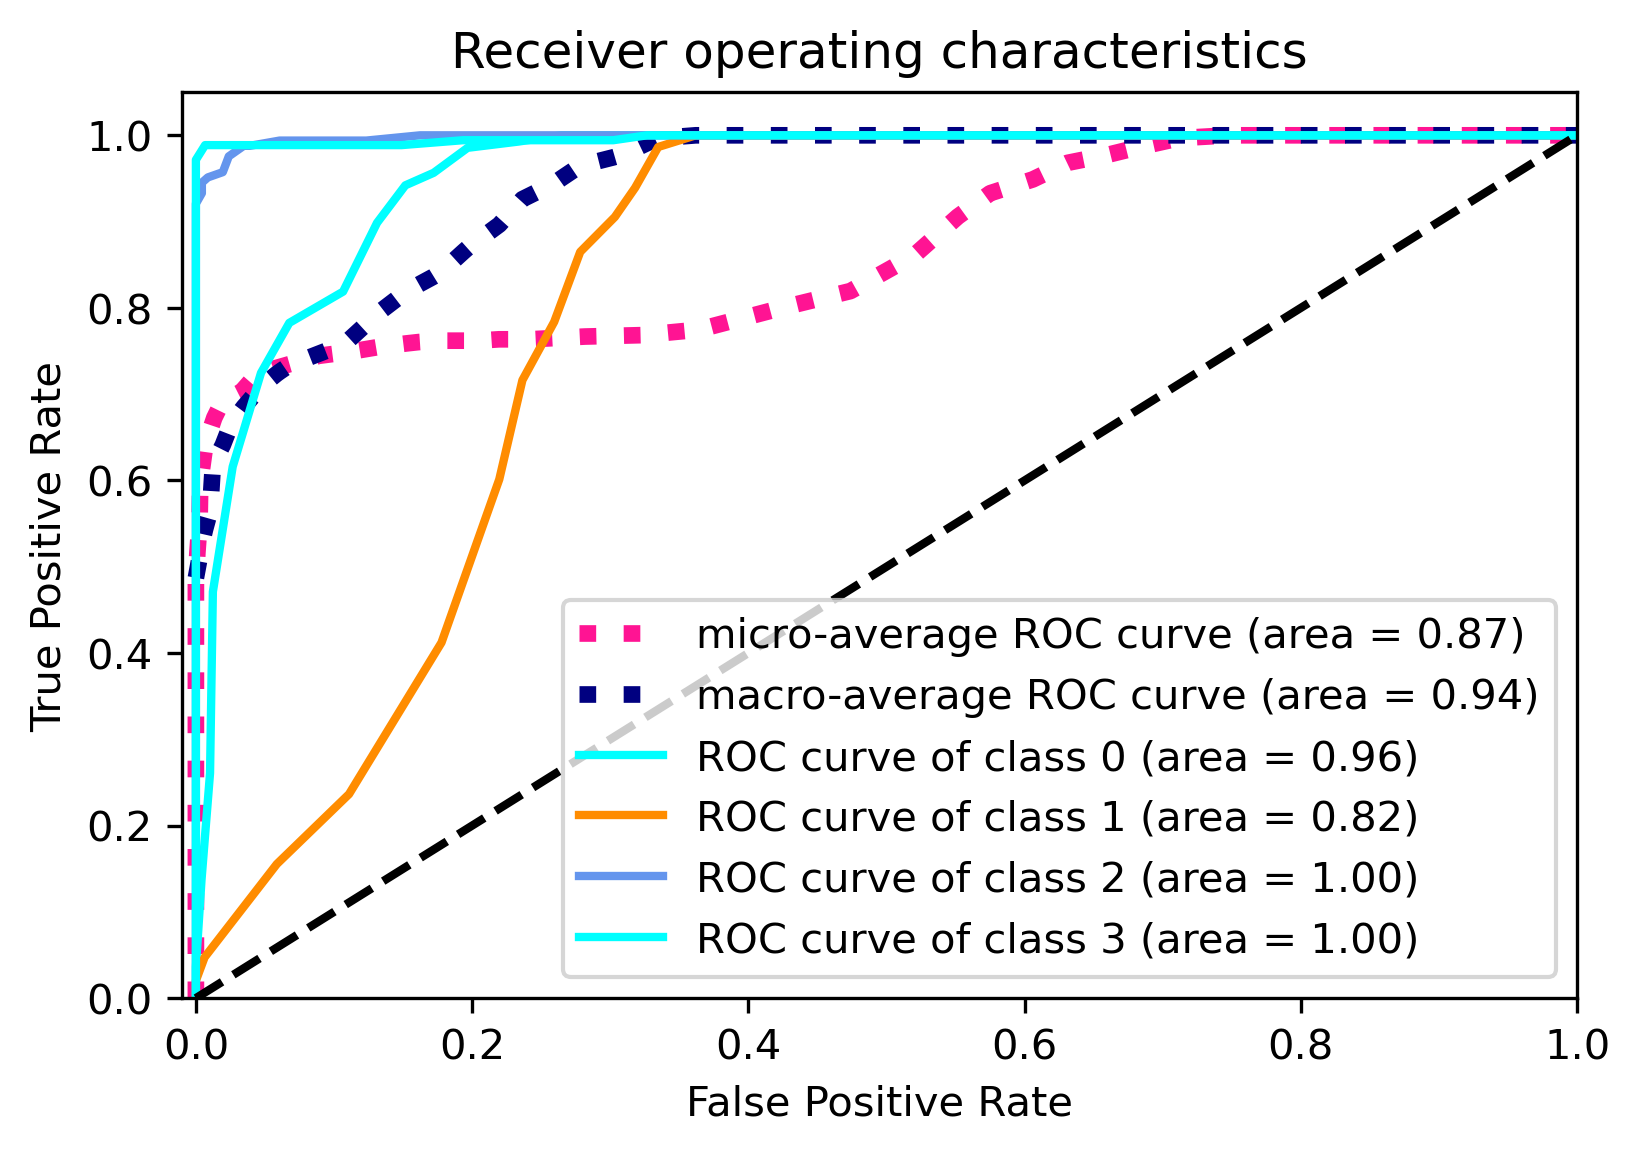

In [13]:
auroc(model.to(device))